In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 18,
}
plt.rcParams.update(font)

from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error

import deepchem as dc
from deepchem.splits.splitters import IndexSplitter, ButinaSplitter, FingerprintSplitter, \
                                        MaxMinSplitter, MolecularWeightSplitter, ScaffoldSplitter
from deepchem.models.tensorgraph.models.graph_models import GraphConvTensorGraph
from deepchem.models.tensorgraph.models.graph_models import MPNNTensorGraph

In [18]:
featurizer = dc.feat.ConvMolFeaturizer()

In [19]:
tasks=["neg RT (min)"]
loader = dc.data.CSVLoader(tasks=tasks, 
                           smiles_field="smiles",
                           featurizer=featurizer,
                           log_every_n=10)
raw_dataset = loader.featurize('../data/combined_time.csv')
raw_dataset = dc.data.datasets.NumpyDataset.from_DiskDataset(raw_dataset)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from ../data/combined_time.csv
Loading shard 1 of size 8192.
Featurizing sample 0
TIMING: featurizing shard 0 took 0.925 s
TIMING: dataset construction took 1.058 s
Loading dataset from disk.


In [20]:
splitter = dc.splits.RandomSplitter()
raw_training_data, raw_testing_data = splitter.train_test_split(raw_dataset)

In [21]:
transformers = [
    dc.trans.NormalizationTransformer(transform_y=True, dataset=raw_training_data)]

transformed_data = []
for dataset in [raw_training_data, raw_testing_data]:
    for transformer in transformers:
          transformed_data.append(transformer.transform(dataset))
training_data, testing_data = tuple(transformed_data)

In [23]:
model = GraphConvTensorGraph(
    n_tasks=1,
    mode='regression',
    batch_size=50,
    model_dir='model01'
)
nb_epoch = 50

In [24]:
%time model.fit(training_data, nb_epoch=nb_epoch, verbose='True')

/localdata0/Code/Python/anaconda3/envs/deepchem_py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Starting epoch 0
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
CPU times: user 59.2 s, sys: 2min 15s, total: 3min 14s
Wall time: 22 s


7.828073710118021

In [25]:
metric = dc.metrics.Metric(dc.metrics.rms_score, mode='regression')
print("Evaluating model")
train_scores = model.evaluate(training_data, [metric])
test_scores = model.evaluate(testing_data, [metric])

print("Training RMS Score: %f" % train_scores["rms_score"])
print("Testing RMS Score: %f" % test_scores["rms_score"])

Evaluating model
computed_metrics: [0.1831893108848143]
computed_metrics: [0.4683674424418594]
Training RMS Score: 0.183189
Testing RMS Score: 0.468367


In [26]:
model.save()

In [27]:
training_predictions = model.predict(training_data)
testing_predictions = model.predict(testing_data)

untransformed_data = []
for dataset in [training_predictions, testing_predictions]:
    for transformer in transformers[-1::-1]:
          untransformed_data.append(transformer.untransform(dataset))
raw_training_predictions, raw_testing_predictions = tuple(untransformed_data)

Text(0.5,1,'Training Dataset (n=318, RMSE=1.95 min)')

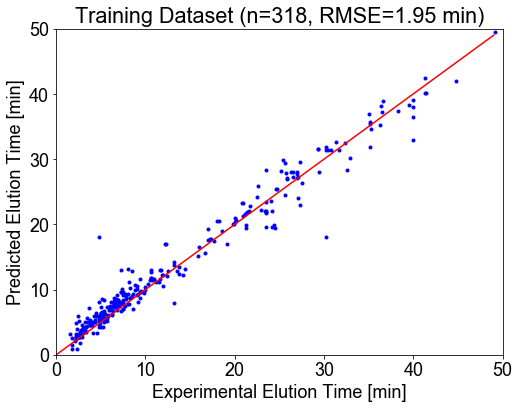

In [28]:
y_expt = raw_training_data.y
y_expt = y_expt.flatten()
y_pred = raw_training_predictions
y_pred = y_pred.flatten()
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt, y_pred, 'b.')
ax1.plot(np.arange(0, max(y_expt)), np.arange(0, max(y_expt)), 'r-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Training Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Training_Performance.png")

In [29]:
bad_molecules = raw_training_data.ids[(np.abs(y_pred - y_expt)) > 2]

print("On Training Data:")
print(f"Percentage of molecules with error > 2 minutes: {len(bad_molecules)*100/len(y_expt):.1f}%")
print(f"Number of molecules with error > 2 minutes: {len(bad_molecules):d}")

On Training Data:
Percentage of molecules with error > 2 minutes: 17.9%
Number of molecules with error > 2 minutes: 57


Text(0.5,1,'Test Dataset (n=80, RMSE=5.00 min)')

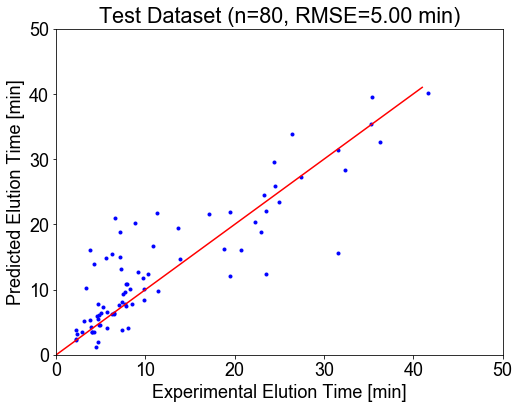

In [30]:
y_expt = raw_testing_data.y
y_expt = y_expt.flatten()
y_pred = raw_testing_predictions
y_pred = y_pred.flatten()
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt, y_pred, 'b.')
ax1.plot(np.arange(0, max(y_expt)), np.arange(0, max(y_expt)), 'r-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Test Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Test_Performance.png")

In [31]:
cutoff = 2
bad_molecules = raw_testing_data.ids[(np.abs(y_pred - y_expt)) > cutoff]

print("On Test Data:")
print(f"Percentage of molecules with error > {cutoff:d} minutes: {len(bad_molecules)*100/len(y_expt):.1f}%")
print(f"Number of molecules with error > {cutoff:d} minutes: {len(bad_molecules):d}")

On Test Data:
Percentage of molecules with error > 2 minutes: 47.5%
Number of molecules with error > 2 minutes: 38
